## Visualization of route statistics

Here we'll do a preliminary investigation of the route data scraped from Mountainproject. 

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import wordcloud as wc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

First let's import the data (json lines file). 

In [2]:
routedata_path='.../routedata.jl' #path to routedata.jl file
df = pd.read_json(routedata_path, lines=True)

Since Mountainproject is mostly a used in the US, let's restrict our visualization to routes in the US. <br/>

In [4]:
df_LocationFirst = df.Location.apply(lambda x: x[0])
df=df[(df_LocationFirst.str.contains('International')==False) & (df_LocationFirst.str.contains('In Progress')==False)]
FS=15 #set font size

## Pie chart of types of routes on Mountainproject

Here we're just counting the types of routes. Routes with mixed trad/boulder or sport/boulder grades are considered to be boulders.

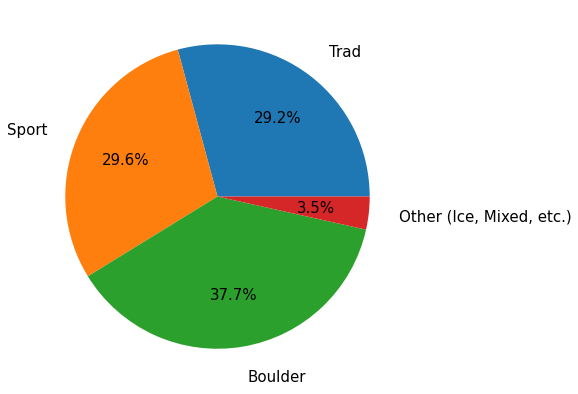

In [83]:
plot_type_piechart()

## Distribution of grades for trad vs sport routes

Here we'll plot the number of trad climbs vs the number of sport climbs in each grade bin (grade as whole #s without subdivision). <br/>

Unsuprisingly, trad climbs dominate at the low-end of the grade scale, while sport climbs dominate at the high-end. The crossover point is at ~5.10, which is the hardest grade that most trad climbers will get to. 

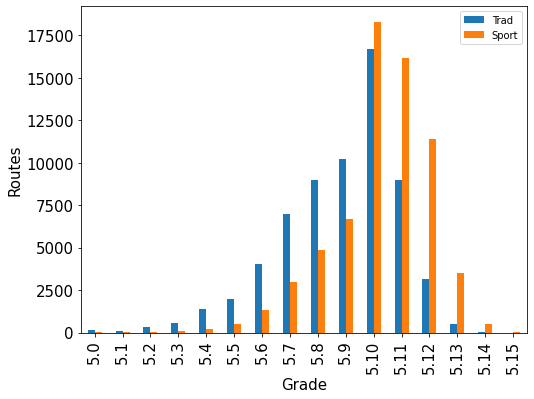

In [86]:
plot_grade_counts()

## Route grade vs difficulty 

Here we're plotting the average star rating of routes vs their difficulty. Interestingly, users tend to rate more difficult climbs higher, and the star rating depends increases more steeply with difficulty for trad climbs vs sport climbs. Note: this is based on a linear scaling of route difficulty when in reality it is probably non-linear

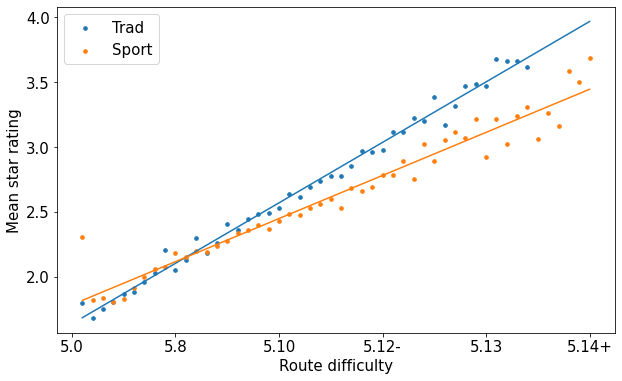

In [151]:
plot_stars_vsrating()

## Routes added vs time

Here we plot number of new routes added to the Mountainproject database each year. <br/>

From this, we can see that bouldering wasn't included as a large part of the original mountainproject database dump in ~2006, but it eventually caught up to sport and trad climbs, and has been growing at a much faster rate recently. 

We can also see that the rate of new boulders being added during covid year was much higher than sport or trad climbs, which makes sense since bouldering is an activity one can easily do alone. 

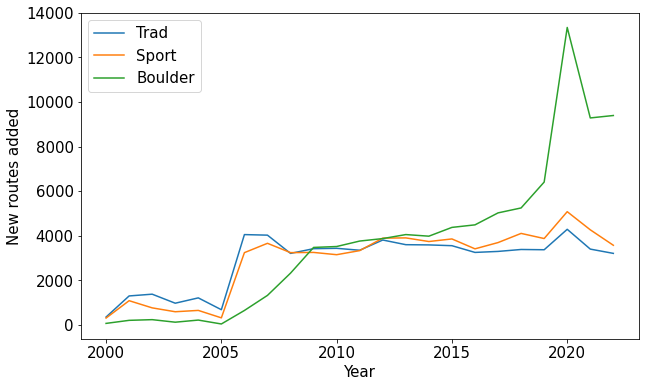

In [150]:
plot_routesadded_vstime()

## Word clouds from notes on trad, sport, boulder, or alpine climbs

Here we plot wordclouds for the notes on ticks of trad,sport,boulders,and alpine routes. <br/>
We see exactly what we expect with regard to which words are found in which route types.

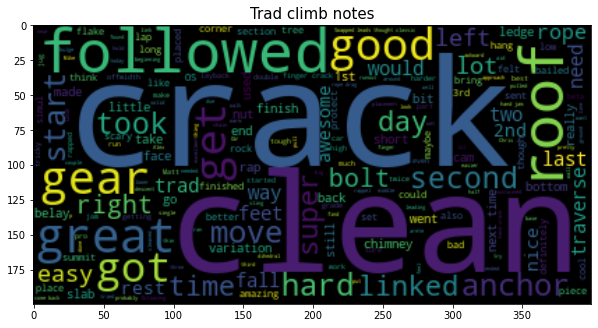

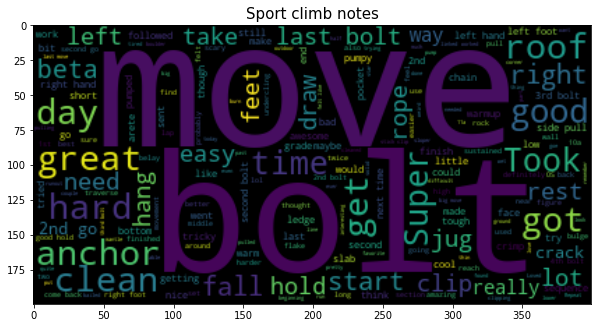

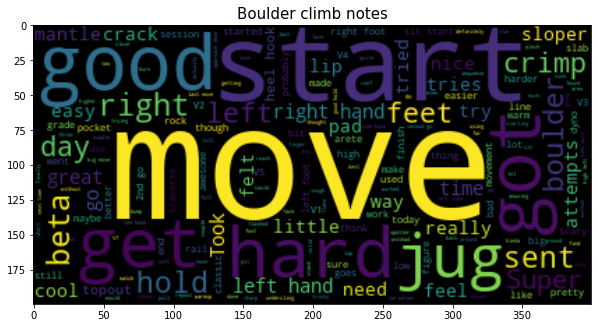

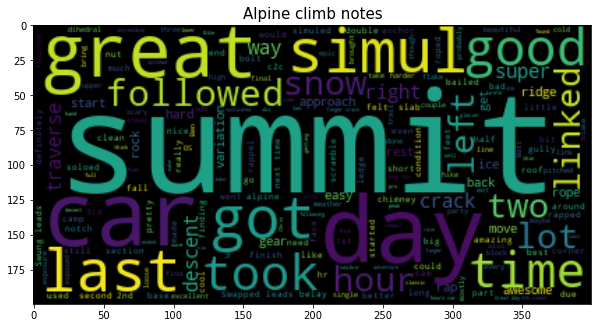

In [153]:
plot_note_wordclouds()

## FA year for all trad, sport, boulders

Here we plot the distribution of FA year for routes on MP for different types. <br/>

Sure enough, trad climb were mostly FA'd pre-1990, when trad climbing was the dominant climbing style. Sport climbing exploded in the early-80s, around the time that hangdogging was becoming acceptable. 

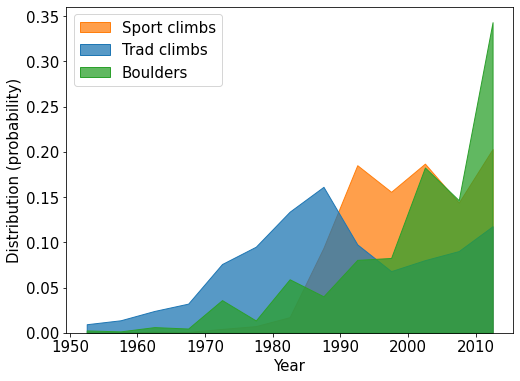

In [96]:
plot_FAyear_distribution()

## Number of star ratings distribution

Here we plot the distribution of number of votes on climbs of different styles. <br/>

As expected, the distribution is long-tailed, since the number of votes a route gets is influenced by a preferrential-attachment process (e.g., popular routes get put in guidebooks, promoted to the classics page, etc). We can also see that there are trad climbs with higher votes than any sport climbs, and likewise for sport vs boulders, reflecting the overall popularity of the disciplines among mountainproject users

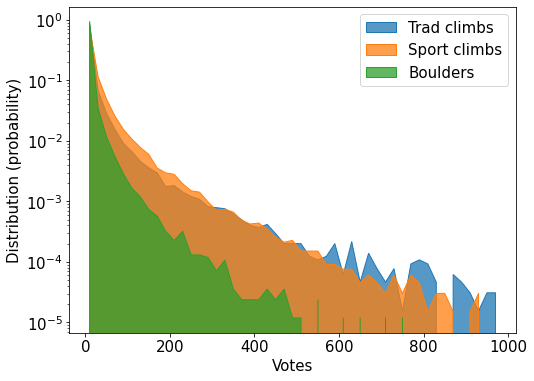

In [97]:
plot_star_distribution()

## Function definitions for plotting

In [82]:
#Create pie chart plot of route types in the US
def plot_type_piechart():
    ## Get number of routes with type containing trad, sport, boulder, or else
    route_typecounts = np.array([0,0,0,0])
    route_typecounts[0] = len([x for x in df.Type if 'Trad' in x and 'Boulder' not in x])
    route_typecounts[1] = len([x for x in df.Type if 'Sport' in x and 'Boulder' not in x])
    route_typecounts[2] = len([x for x in df.Type if 'Boulder' in x])
    other_percentage = len(df.Type.index)-sum(route_typecounts)
    route_typecounts[3] = other_percentage
    route_typecounts = route_typecounts*(1/len(df.Type.index))

    route_typecounts = route_typecounts*(1/sum(route_typecounts))
    labels = ['Trad', 'Sport', 'Boulder', 'Other (Ice, Mixed, etc.)']

    #Make plot
    plt.figure(figsize=(7,7))
    plt.pie(route_typecounts, labels=labels, autopct='%.1f%%', pctdistance=0.65, labeldistance=1.2, textprops={'fontsize': 15})
    plt.show()

In [85]:
#Create bar chart distribution of route ratings for trad and sport climbs
def gradecounter(ratings):
    #Count how many of each grade appear in the database
    grades = ['5.0', '5.1',  '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9',
                 '5.10', '5.11', '5.12', '5.13', '5.14','5.15']
    counts = len(grades)*[0]
    for rating in ratings: #For each rating
        #Find if it is held in the grade list
        rating =  re.sub(r"[a-z\+\-/]", '',rating)
        if rating in grades:
            ind = grades.index(rating)
            counts[ind] += 1 #Add count to counts
    return counts

def plot_grade_counts():
    
    #Define rounded grades
    grades = ['5.0', '5.1',  '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9',
                     '5.10', '5.11', '5.12', '5.13', '5.14','5.15']
    df_plot = pd.DataFrame.from_dict({'Grade': grades,
                                      'Trad': gradecounter(df.RatingYDS.loc[df.Type.str.contains('Trad')].dropna()),
                                      'Sport': gradecounter(df.RatingYDS.loc[df.Type.str.contains('Sport')].dropna())
                                     })
    #Make plot
    ax = df_plot.plot(x="Grade", y=["Trad", "Sport"], kind="bar", figsize=(8,6))
    ax.set_xlabel('Grade',fontdict={'fontsize':FS})
    ax.set_ylabel('Routes',fontdict={'fontsize':FS})
    ax.tick_params(labelsize=FS)

In [147]:
#Define a function that convert route grades to a score
def grade_to_score(input_grades):
    grades_yds = ['5.0','5.1','5.2','5.3','5.4','5.5','5.6','5.7','5.7+','5.8-','5.8','5.8+','5.9-','5.9','5.9+',
                  '5.10a',['5.10-','5.10a/b'],'5.10b',['5.10','5.10b/c'],'5.10c',['5.10+','5.10c/d'],'5.10d',
                  '5.11a',['5.11-','5.11a/b'],'5.11b',['5.11','5.11b/c'],'5.11c',['5.11+','5.11c/d'],'5.11d',
                  '5.12a',['5.12-','5.12a/b'],'5.12b',['5.12','5.12b/c'],'5.12c',['5.12+','5.12c/d'],'5.12d',
                  '5.13a',['5.13-','5.13a/b'],'5.13b',['5.13','5.13b/c'],'5.13c',['5.13+','5.13c/d'],'5.13d',
                  '5.14a',['5.14-','5.14a/b'],'5.14b',['5.14','5.14b/c'],'5.14c',['5.14+','5.14c/d'],'5.14d',
                  '5.15a',['5.15-','5.15a/b'],'5.15b',['5.15','5.15b/c'],'5.15c',['5.15+','5.15c/d'],'5.15d']
                  
    ref_scores = np.arange(1, len(grades_yds)+1,1) #this can be nonlinearized later
    output_scores = len(input_grades)*[0]

    for j,grade in enumerate(input_grades): #for each grade string
        for i,val in enumerate(grades_yds): #for each 
            if isinstance(val,str):
                found = grade == val
            else:
                found = any([grade == el for el in val])
            if found: 
                output_scores[j] = ref_scores[i]
    return output_scores

def get_stars_vs_scores(search_string):
            
    #Calculate scores of all trad climbs
    route_scores = np.array(grade_to_score(df[(df.Type.str.contains(search_string)) &
                                             (df.RatingYDS.str.contains('5\.'))&
                                             (df.Stars>0)].RatingYDS.tolist()))
    route_stars = np.array(df[(df.Type.str.contains(search_string)) &
                           (df.RatingYDS.str.contains('5\.'))&
                           (df.Stars>0)].Stars.tolist())

    #Calculate mean and standard deviation
    cutoff=10
    unique_scores = np.unique(route_scores)
    star_count = np.array([len(route_stars[route_scores==score]) for score in unique_scores])
    star_mean = np.array([np.mean(route_stars[route_scores==score]) for score in unique_scores])[star_count>cutoff]
    star_sd = np.array([np.std(route_stars[route_scores==score]) for score in unique_scores])[star_count>cutoff]
    unique_scores = unique_scores[star_count>cutoff]
    uinque_scores = list(unique_scores)
    return unique_scores, star_mean, star_sd



def plot_stars_vsrating():
    
    scores1, stars1, star_err1 = get_stars_vs_scores('Trad')
    scores2, stars2, star_err2 = get_stars_vs_scores('Sport')
    
    fig, ax1 = plt.subplots(1,1, figsize=(10, 6))
    data1 = ax1.scatter(scores1, stars1, color='tab:blue', s=13)
    data2 = ax1.scatter(scores2, stars2, color='tab:orange', s=13)
    ax1.set_xlabel('Route difficulty',fontdict={'fontsize':FS})
    ax1.set_ylabel('Mean star rating',fontdict={'fontsize':FS})
    ax1.legend([data1, data2], ['Trad', 'Sport'], fontsize = FS)
    ax1.tick_params(labelsize=FS)
    ax1.set_xticklabels(['5.0','5.0', '5.8', '5.10','5.12-','5.13','5.14+' ])


#     #Plot data with errorbars
#     (_, caps1, _) = ax2.errorbar(scores1, stars1, yerr=star_err1, fmt='.', markersize=8, capsize=3, color='tab:blue')
#     (_, caps2, _) = ax2.errorbar(scores2, stars2, yerr=star_err2, fmt='.', markersize=8, capsize=3, color='tab:orange')
#     ax2.set_xlabel('Route difficulty',fontdict={'fontsize':FS})
#     ax2.set_ylabel('Mean star rating +- std. deviation',fontdict={'fontsize':FS})
#     ax2.tick_params(labelsize=FS)
#     ax2.set_xticklabels(['5.0','5.0', '5.8', '5.10','5.12-','5.13','5.14+' ])

#     #Adjust errorbar cap size
#     for cap in caps1:
#         cap.set_markeredgewidth(1)
#     for cap in caps2:
#         cap.set_markeredgewidth(1)

    #Fit lines and plot
    slope1, int1 = np.polyfit(scores1, stars1, 1) #fit a line to the data
    slope2, int2 = np.polyfit(scores2, stars2, 1) #fit a line to the data
    x=np.linspace(np.min(scores2), np.max(scores2), 100)

    ax1.plot(x, slope1*x+int1, color='tab:blue')  
    ax1.plot(x, slope2*x+int2, color='tab:orange')    

In [93]:
def plot_routesadded_vstime():
    #Dates added for trad climbs
    dates_trad = pd.to_datetime(df.DateAdded[(df.Type.str.contains('Trad')) & (df.Type.str.contains('Boulder')==False)])
    dates_sport = pd.to_datetime(df.DateAdded[(df.Type.str.contains('Sport')) & (df.Type.str.contains('Boulder')==False)])
    dates_boulder = pd.to_datetime(df.DateAdded[(df.Type.str.contains('Boulder'))])

    df_plot = pd.DataFrame({'Trad': dates_trad.groupby(dates_trad.dt.year).count(),
                           'Sport': dates_sport.groupby(dates_sport.dt.year).count(),
                           'Boulder': dates_boulder.groupby(dates_boulder.dt.year).count(),
                           'Trad_Diff': dates_trad.groupby(dates_trad.dt.year).count().diff(),
                           'Sport_Diff': dates_sport.groupby(dates_sport.dt.year).count().diff(),
                           'Boulder_Diff': dates_boulder.groupby(dates_boulder.dt.year).count().diff()},
                           index=dates_sport.groupby(dates_sport.dt.year).count().index)


    # Do plotting
    fig,ax1 = plt.subplots(1,1, figsize=(10, 6))

    line1, = ax1.plot(df_plot.index[0:-1], df_plot.Trad[0:-1])
    line2, = ax1.plot(df_plot.index[0:-1], df_plot.Sport[0:-1])
    line3, = ax1.plot(df_plot.index[0:-1], df_plot.Boulder[0:-1])
    ax1.set_xlabel('Year',fontdict={'fontsize':FS})
    ax1.set_ylabel('New routes added',fontdict={'fontsize':FS})
    ax1.tick_params(labelsize=FS)
    ax1.legend([line1, line2, line3], ['Trad','Sport', 'Boulder'], fontsize=FS)

In [152]:
#Get every note row from every trad climb (includes names, dates, and notes.)
def getwordcloudfromtypenotes(search_string):
    from nltk.corpus import stopwords
    all_notes = []
    if search_string != 'Boulder':
        boolind=(df.Type.str.contains(search_string)) & (df.Type.str.contains('Boulder')==False)
    else:
        boolind=(df.Type.str.contains('Boulder')==True)
        
    for row in df.StatsInfo[boolind]: #All trad rows
        try:
            ticks = row['Ticks'] #list of lists
            route_notes = [x[1::] for x in ticks if len(x) > 1] #get rid of name
            route_notes = [val.replace('·','').strip() for nestedlist 
                           in route_notes for val in nestedlist] #add to one big ol list
            all_notes.extend(route_notes)

        except:
            pass

    all_notes =[x for x in all_notes if ('19' not in x)&('20' not in x)] #gets rid of date strings
    exclude_list = ['Lead / Onsight', 'Lead / Redpoint', 'Lead /Fell/Hung', 
                    'Lead', 'Lead / Pinkpoint', 'Lead / Flash',
                    'Follow', 'TR', 'Solo', 'Send', 'Attempt', 'Flash']

    all_notes = [x for x in all_notes if len(x.split(' '))>3] #gets rid of most names
    all_notes = {'Notes': all_notes}
    df_word = pd.DataFrame.from_dict(all_notes) #create a new dataframe from all the notes
    

    # # Create stopword list:
    stopwords = set(stopwords.words('english'))
    stopwords.update(["Lead", "Onsight","Redpoint","Fell","Hung","Pinkpoint","Flash","Send","Attempt","TR","Solo",
                     'Lead / Onsight', 'Lead / Redpoint', 'Lead /Fell/Hung', 'Lead', 'Lead / Pinkpoint', 'Lead / Flash',
                    'Follow', 'TR', 'Solo', 'Send', 'Attempt', 'Flash', 'led', 'pitch', 'pitches', 'climb','w', 'route',
                     'problem', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6','climbed', 'fun','crux','top','first','climbing', 'one'])
    notes = " ".join(review for review in df_word.Notes)
    wordcloud = wc.WordCloud(stopwords=stopwords).generate(notes)
    return wordcloud

def plot_note_wordclouds():
    wc_trad = getwordcloudfromtypenotes('Trad')
    wc_sport = getwordcloudfromtypenotes('Sport')
    wc_boulder = getwordcloudfromtypenotes('Boulder')
    wc_alpine = getwordcloudfromtypenotes('Alpine')

    #Plot word clouds
    fsize = (10,10)
    fig = plt.figure(figsize=fsize)
    ax = fig.add_subplot(111)
    ax.imshow(wc_trad, interpolation='bilinear')
    ax.set_aspect(1)
    ax.set_title('Trad climb notes',fontdict={'fontsize':FS})
    plt.show()

    fig = plt.figure(figsize=fsize)
    ax = fig.add_subplot(111)
    ax.imshow(wc_sport, interpolation='bilinear')
    ax.set_aspect(1)
    ax.set_title('Sport climb notes',fontdict={'fontsize':FS})
    plt.show()


    fig = plt.figure(figsize=fsize)
    ax = fig.add_subplot(111)
    ax.imshow(wc_boulder, interpolation='bilinear')
    ax.set_aspect(1)
    ax.set_title('Boulder climb notes',fontdict={'fontsize':FS})
    plt.show()


    fig = plt.figure(figsize=fsize)
    ax = fig.add_subplot(111)
    ax.imshow(wc_alpine, interpolation='bilinear')
    ax.set_aspect(1)
    ax.set_title('Alpine climb notes',fontdict={'fontsize':FS})
    plt.show()

In [94]:
def plot_FAyear_distribution():
    #Extract first year number outof FA:

    df_FA_trad = df.FA[(df.FA.apply(lambda string:bool(re.search(r'\d{4}', string)))) & (df.Type.str.contains('Trad'))] #trad climb FA's
    FA_trad = [int(x) for x in df_FA_trad.apply(lambda string:re.search("\d{4}", string).group(0))] #only years

    df_FA_sport = df.FA[(df.FA.apply(lambda string:bool(re.search(r'\d{4}', string)))) & (df.Type.str.contains('Sport'))] #trad climb FA's
    FA_sport = [int(x) for x in df_FA_sport.apply(lambda string:re.search("\d{4}", string).group(0))] #only years

    df_FA_boulder = df.FA[(df.FA.apply(lambda string:bool(re.search(r'\d{4}', string)))) & (df.Type.str.contains('Boulder'))] #trad climb FA's
    FA_boulder = [int(x) for x in df_FA_boulder.apply(lambda string:re.search("\d{4}", string).group(0))] #only years

    #Plot histograms
    fig, ax = plt.subplots(figsize=(8, 6))
    bins = np.arange(1950,2020,5)
    sns.histplot(FA_sport, bins=bins, ax=ax, kde=False,stat='probability', color='tab:orange', element="poly")
    sns.histplot(FA_trad, bins=bins, ax=ax, kde=False,stat='probability', color='tab:blue', element="poly")
    sns.histplot(FA_boulder, bins=bins, ax=ax, kde=False,stat='probability', color='tab:green', element="poly")
    plt.legend(labels=["Sport climbs","Trad climbs", "Boulders"], fontsize=FS, loc='upper left')
    ax.set_xlabel('Year',fontdict={'fontsize':FS})
    ax.set_ylabel('Distribution (probability)',fontdict={'fontsize':FS})
    ax.tick_params(labelsize=FS)

In [95]:
def plot_star_distribution():
    masktrad = (df.Type.str.contains('Trad')) & (df.Type.str.contains('Boulder')==False)
    masksport = df.Type.str.contains('Sport') & (df.Type.str.contains('Boulder')==False)
    maskboulder = df.Type.str.contains('Boulder')
    def percent_zero_votes(mask):
        p = 100*sum(df.Votes[mask]==0)/len(df.Votes[mask].index)
        return p
    #Percent of climbs of each type that have zero votes
    p = [percent_zero_votes(masktrad),percent_zero_votes(masksport),percent_zero_votes(maskboulder)]

    votes_trad = df.Votes[(masktrad) & (df.Votes > 0)]
    votes_sport =  df.Votes[(masksport) & (df.Votes > 0)]
    votes_boulder =  df.Votes[(maskboulder) & (df.Votes > 0)]

    fig, ax = plt.subplots(figsize=(8, 6))
    bins=np.arange(0,1000,20)
    sns.histplot(votes_trad,bins=bins, ax=ax,stat='probability', color='tab:blue',log_scale=(False,True), element="poly")
    sns.histplot(votes_sport,bins=bins, ax=ax, stat='probability', color='tab:orange',log_scale=(False,True), element="poly")
    sns.histplot(votes_boulder,bins=bins, ax=ax, stat='probability', color='tab:green',log_scale=(False,True), element="poly")
    ax.set_xlabel('Votes',fontdict={'fontsize':FS})
    ax.set_ylabel('Distribution (probability)',fontdict={'fontsize':FS})
    ax.tick_params(labelsize=FS)
    plt.legend(labels=["Trad climbs","Sport climbs", "Boulders"], fontsize=FS, loc='upper right')